<a href="https://colab.research.google.com/github/Pytlovan/PDI_M3/blob/main/Classifica%C3%A7%C3%A3o_de_Imagens_Braile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carregando as dependências

In [ ]:
!pip install gTTS

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from google.colab.patches import cv2_imshow
from google.colab import drive
from sklearn.cluster import KMeans
from tqdm import tqdm
from queue import Queue
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import display, Javascript, Audio
from google.colab.output import eval_js
from gtts import gTTS
import base64
from google.colab import output


drive.mount('/content/drive/')

Mounted at /content/drive/


## Carrega base e tratado para treinamento e teste

In [ ]:
from PIL import Image

from sklearn.model_selection import train_test_split


# Valores para label das imagens
class_names = ['a', 'b', 'c', 'd', 'e',
               'f', 'g', 'h', 'i', 'j',
               'k', 'l', 'm', 'n', 'o',
               'p', 'q', 'r', 's', 't',
               'u', 'v', 'w', 'x', 'y',
               'z']

# Diretório da base de imagens
diretorio = Path('/content/drive/MyDrive/DatasetBraile/Option1/Braille Dataset/Braille Dataset')

# Filtro para pegar somente as imagens
dir_list = list(diretorio.glob('*.jpg'))

# Listas para armazenar imagens e labels
nomes = []
train_images = []
labels = []

# Carrega as imagens e aplica pré-processamento
for dir in dir_list:
    # Carrega a imagem
    image = cv2.imread(str(dir))

    # Converte para escala de cinza e redimensiona
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32, 32))

    # Binarização baseada na média da imagem
    if np.mean(image) < 100:
        limite = 20
    else:
        limite = 50

    #Aplicando binarização
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        if image[i, j] > limite:
          image[i, j] = 255
        else:
          image[i, j] = 0

    # Aplicando filtro para suavizar a imagem e remover os ruídos
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.medianBlur(image, 5)

    # Adiciona imagens e labels para treinamento
    train_images.append(image)
    nome = str(dir)
    nome = nome.lower()
    labels.append(class_names.index(nome[77]))

    nomes.append(nome)

    #print("Imagem antes do data augmentation")
    #cv2_imshow(image)

    # Aplicação de data augmentation com TensorFlow
    image = tf.expand_dims(image, axis=0)  # Adiciona dimensão de lote para compatibilidade
    image_data_augmentation = tf.image.central_crop(image, central_fraction=0.8)
    image_data_augmentation = tf.squeeze(image_data_augmentation, axis=0)  # Remove dimensão de lote
    image_data_augmentation = image_data_augmentation.numpy()
    image_data_augmentation = cv2.resize(image_data_augmentation,(32,32))
    # Converte para numpy array e adiciona à lista de imagens de treinamento

    # Adiciona imagens pós Data Augmentation e labels para treinamento
    augmented_image = image_data_augmentation.astype(np.float32)
    #print("Imagem pós data augmentation")
    #cv2_imshow(augmented_image)
    train_images.append(augmented_image)
    nome = str(dir)
    nome = nome.lower()
    labels.append(class_names.index(nome[77]))

    nomes.append(nome)


# Convertendo para numpy arrays
train_images = np.array(train_images, dtype=np.float32) / 255.0
labels = np.array(labels)

# Separando em conjuntos de treinamento e teste
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Verificação final
print(f"Training set size: {len(train_images)}")
print(f"Testing set size: {len(test_images)}")


Training set size: 2496
Testing set size: 624


## Criação da Rede Neural com as camadas convolucionais

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.25))  # Ajusta a taxa de dropout

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))  # Ajusta a taxa de dropout
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))  # Usa softmax para classificação de múltiplas classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

## Compila o modelo com o Histórico de Execução da Rede

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=200,
                    validation_data=(test_images, test_labels))



Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


78/78 [==============================] - 6s 46ms/step - loss: 0.1243 - accuracy: 0.9539 - val_loss: 0.3744 - val_accuracy: 0.9199
Epoch 2/200
78/78 [==============================] - 3s 44ms/step - loss: 0.1120 - accuracy: 0.9651 - val_loss: 0.3444 - val_accuracy: 0.9071
Epoch 3/200
78/78 [==============================] - 4s 56ms/step - loss: 0.1299 - accuracy: 0.9539 - val_loss: 0.2828 - val_accuracy: 0.9103
Epoch 4/200
78/78 [==============================] - 5s 60ms/step - loss: 0.1361 - accuracy: 0.9539 - val_loss: 0.3298 - val_accuracy: 0.9231
Epoch 5/200
78/78 [==============================] - 3s 43ms/step - loss: 0.1177 - accuracy: 0.9599 - val_loss: 0.2954 - val_accuracy: 0.9231
Epoch 6/200
78/78 [==============================] - 3s 43ms/step - loss: 0.1134 - accuracy: 0.9623 - val_loss: 0.3115 - val_accuracy: 0.9215
Epoch 7/200
78/78 [==============================] - 7s 91ms/step - loss: 0.1173 - accuracy: 0.9583 - val_loss: 0.3255 - val_accuracy: 0.9215
Epoch 8/200
78/78 

## Plota gráfico do histórico da Rede

20/20 - 0s - loss: 0.3558 - accuracy: 0.9103 - 248ms/epoch - 12ms/step
0.9102563858032227


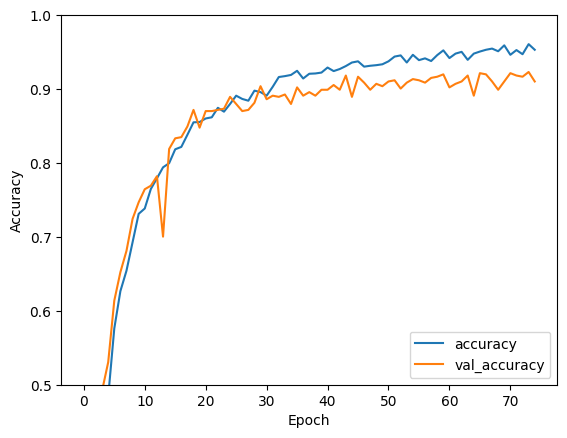

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

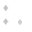

1/1 [==============================] - 0s 22ms/step
a: 0.00%
b: 0.00%
c: 0.00%
d: 0.00%
e: 0.00%
f: 0.00%
g: 0.00%
h: 0.00%
i: 0.00%
j: 0.00%
k: 0.00%
l: 0.00%
m: 0.00%
n: 0.00%
o: 0.00%
p: 0.00%
q: 0.00%
r: 0.53%
s: 0.00%
t: 0.00%
u: 0.00%
v: 99.47%
w: 0.00%
x: 0.00%
y: 0.00%
z: 0.00%

Label Verdadeiro: h
Predição: v
Resultado: Errado



In [ ]:
def show_image_and_probabilities(image_index):
    image = test_images[image_index]
    true_label = class_names[test_labels[image_index]]
    cv2_imshow((image * 255).astype(np.uint8))  # Mostrar a imagem

    prediction = model.predict(np.expand_dims(image, axis=0))
    probabilities = prediction[0]

    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob:.2%}")

    predicted_label = class_names[np.argmax(probabilities)]
    print(f"\nLabel Verdadeiro: {true_label}")
    print(f"Predição: {predicted_label}")

    if true_label == predicted_label:
        print("Resultado: Correto")
    else:
        print("Resultado: Errado")
    print()

# Exemplo de uso da função
image_index = 55  # Escolha o índice da imagem que deseja visualizar
show_image_and_probabilities(image_index)

## Captura da Foto

<IPython.core.display.Javascript object>

Imagem capturada


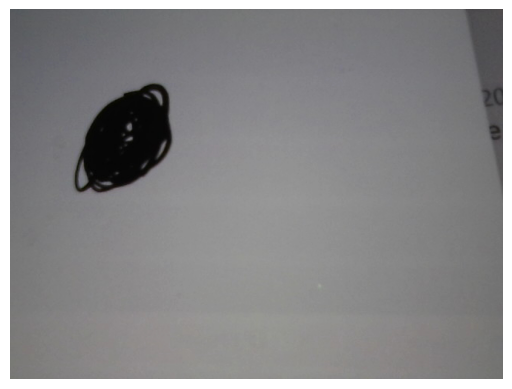

In [ ]:
# Variável global para armazenar a imagem capturada
captured_image = None

# Função para capturar a foto usando a webcam
def take_photo(filename='photo.jpg', quality=1):
    # JavaScript para capturar a imagem da webcam
    js = Javascript('''
    async function takePhoto(quality) {
        // Cria um div e um botão para capturar a imagem
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Tirar Foto';  // Texto do botão
        div.appendChild(capture);

        // Cria um elemento de vídeo para exibir a webcam
        const video = document.createElement('video');
        video.style.display = 'block';  // Exibe o vídeo em um bloco
        const stream = await navigator.mediaDevices.getUserMedia({video: true});  // Solicita acesso à webcam

        // Adiciona o vídeo e o botão ao documento
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;  // Define a fonte do vídeo como a webcam
        await video.play();  // Reproduz o vídeo

        // Redimensiona a saída para o tamanho do vídeo
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Aguarda o botão ser clicado
        await new Promise((resolve) => capture.onclick = resolve);

        // Cria um canvas para capturar a imagem da webcam
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        // Desenha a imagem da webcam no canvas
        canvas.getContext('2d').drawImage(video, 0, 0);
        // Para o vídeo e remove os elementos da página
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        // Converte a imagem do canvas para o formato base64
        const img = canvas.toDataURL('image/jpeg', quality);
        return img;  // Retorna a imagem em formato base64
    }

    // Executa a função JavaScript e envia a imagem capturada para o Python
    takePhoto(%f).then(img => google.colab.kernel.invokeFunction('notebook.get_photo', [img], {}));
    ''' % quality)

    display(js)  # Exibe e executa o JavaScript

# Função Python para processar a imagem capturada
def get_photo(img):
    global captured_image  # Referencia a variável global para armazenar a imagem
    # Converte a string base64 para bytes
    img_data = base64.b64decode(img.split(',')[1])
    # Converte os bytes para um array NumPy
    np_img = np.frombuffer(img_data, dtype=np.uint8)
    # Decodifica o array NumPy para uma imagem usando OpenCV
    captured_image = cv2.imdecode(np_img, cv2.IMREAD_COLOR)

    print("Imagem capturada")  # Mensagem de confirmação

    # Exibe a imagem capturada usando Matplotlib
    plt.imshow(cv2.cvtColor(captured_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Não exibe os eixos
    plt.show()
    return captured_image # Return the captured image

# Registra a função get_photo como callback para ser chamada do JavaScript
output.register_callback('notebook.get_photo', get_photo)

# Chama a função para capturar a imagem
take_photo()


## Reconhecimento da Foto

1/1 [==============================] - 0s 24ms/step
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


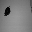

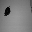

1/1 [==============================] - 0s 24ms/step
a: 0.00%
b: 100.00%
c: 0.00%
d: 0.00%
e: 0.00%
f: 0.00%
g: 0.00%
h: 0.00%
i: 0.00%
j: 0.00%
k: 0.00%
l: 0.00%
m: 0.00%
n: 0.00%
o: 0.00%
p: 0.00%
q: 0.00%
r: 0.00%
s: 0.00%
t: 0.00%
u: 0.00%
v: 0.00%
w: 0.00%
x: 0.00%
y: 0.00%
z: 0.00%
Predição: b


In [ ]:
grayscale_image = cv2.cvtColor(captured_image, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(grayscale_image, (32, 32))

'''

# Binarização baseada na média da imagem
if np.mean(resized_image) < 100:
    limite = 20
else:
    limite = 50

#Aplicando binarização
for i in range(resized_image.shape[0]):
    for j in range(resized_image.shape[1]):
      if resized_image[i, j] > limite:
        resized_image[i, j] = 255
      else:
        resized_image[i, j] = 0



# Aplicando filtro para suavizar a imagem e remover os ruídos
resized_image = cv2.GaussianBlur(resized_image, (3, 3), 0)
resized_image = cv2.medianBlur(resized_image, 5)
'''


image2test = resized_image
#image2test = np.stack((image2test,)*3, axis=-1)
image2test = image2test.reshape((-1,32,32,1))
print(model.predict(image2test))

cv2_imshow(resized_image)
resized_image = np.expand_dims(resized_image, axis=-1)

cv2_imshow(resized_image)

prediction = model.predict(np.expand_dims(resized_image, axis=0))
probabilities = prediction[0]




for i, prob in enumerate(probabilities):
      print(f"{class_names[i]}: {prob:.2%}")

predicted_label = class_names[np.argmax(probabilities)]

print(f"Predição: {predicted_label}")



## Fala o caracter mais provável

In [ ]:
tts = gTTS(predicted_label,lang='pt')
tts.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=True)